In [1]:
#basics
import pandas as pd
import numpy as np
import tensorflow as tf
import keras

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#utility & processing
from tensorflow.keras import utils
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

#cnn architecture
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Sequential

#callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

#data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#keras tuner
# import keras_tuner
# from keras_tuner import RandomSearch
# from keras_tuner.engine.hyperparameters import HyperParameters

#transfer learning
from keras.applications.vgg16 import VGG16

#warnings
import warnings
warnings.filterwarnings('ignore')


print('we are currently using tensorflow version', tf.__version__)

2024-04-11 20:06:03.778530: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 20:06:04.744215: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


we are currently using tensorflow version 2.13.0


In [2]:
train_dir = r'data/RiceLeafsDisease/train/'
test_dir = r'data/RiceLeafsDisease/validation/'

val_loss = list()
val_accuracy = list()
test_loss= list()
test_accuracy = list()

In [3]:
BATCH_SIZE = 32
seeds = 41
im_shape = (250,250)

In [4]:
# Load and preprocess the training data
train_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
val_data_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True,validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1./255, rotation_range=40,shear_range=0.2, zoom_range=0.2,width_shift_range=0.2,horizontal_flip=True)

# Generator of Train
train_generator = train_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=True, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="training")
# Generator of validation
validation_generator = val_data_generator.flow_from_directory(train_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE, subset="validation")

# Generator of dataset test
test_generator = test_generator.flow_from_directory(test_dir, target_size=im_shape, shuffle=False, seed=seeds,
                                                     class_mode='categorical',color_mode='rgb', batch_size=BATCH_SIZE)

nb_train_samples = train_generator.samples
nb_validation_samples = validation_generator.samples
nb_test_samples = test_generator.samples
classes = list(train_generator.class_indices.keys())
print('Classes: '+str(classes))
num_classes  = len(classes)


Found 1680 images belonging to 6 classes.
Found 420 images belonging to 6 classes.
Found 528 images belonging to 6 classes.
Classes: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot']


## VGG16

In [5]:
from tensorflow.keras.applications import VGG16

In [6]:
vgg_base = VGG16(  
    include_top=False,  
    weights='imagenet',  
    input_shape=(250, 250, 3),  
)  
    
vgg_base.trainable = False  

set_trainable = False  

for layer in vgg_base.layers:  
    if layer.name == 'block5_conv1':  
        set_trainable = True  
    if set_trainable:  
        layer.trainable = True  


vgg_model = Sequential()  
  
vgg_model.add(vgg_base)  
  
vgg_model.add(Flatten())  

vgg_model.add(Dense(200, activation='relu'))  
vgg_model.add(Dropout(0.5))
  
vgg_model.add(Dense(6, activation='softmax')) 

2024-04-11 20:06:14.243356: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 20:06:14.253993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 20:06:14.254317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
vgg_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 200)               5017800   
                                                                 
 dropout (Dropout)           (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 6)                 1206      
                                                                 
Total params: 19733694 (75.28 MB)
Trainable params: 5019006 (19.15 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [8]:
#compiling 
vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [9]:
import time
# Record the start time of training
start_time = time.time()

In [10]:
# Train the model
epochs = 10

#Training
history_2 = vgg_model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/10


2024-04-11 20:06:28.962465: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2024-04-11 20:06:31.311690: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-04-11 20:06:31.408313: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x1ee2af60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-11 20:06:31.408362: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-04-11 20:06:31.416284: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-11 20:06:31.593582: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the proce

53/53 [==============================] - 55s 933ms/step - loss: 1.7912 - accuracy: 0.3720 - val_loss: 1.1934 - val_accuracy: 0.5333
Epoch 2/10
53/53 [==============================] - 50s 936ms/step - loss: 1.2064 - accuracy: 0.5238 - val_loss: 1.0385 - val_accuracy: 0.6548
Epoch 3/10
53/53 [==============================] - 49s 921ms/step - loss: 1.0516 - accuracy: 0.5774 - val_loss: 1.0128 - val_accuracy: 0.5881
Epoch 4/10
53/53 [==============================] - 49s 931ms/step - loss: 1.0038 - accuracy: 0.5935 - val_loss: 0.9703 - val_accuracy: 0.6690
Epoch 5/10
53/53 [==============================] - 50s 946ms/step - loss: 0.9759 - accuracy: 0.6000 - val_loss: 0.8573 - val_accuracy: 0.6476
Epoch 6/10
53/53 [==============================] - 51s 953ms/step - loss: 0.9633 - accuracy: 0.6113 - val_loss: 0.8487 - val_accuracy: 0.6905
Epoch 7/10
53/53 [==============================] - 62s 1s/step - loss: 0.9217 - accuracy: 0.6298 - val_loss: 0.8690 - val_accuracy: 0.6548
Epoch 8/10
53

In [11]:
# Record the training end time
end_time = time.time()

In [12]:
training_time = end_time - start_time
print(f"Training time: {training_time} seconds")

Training time: 596.8055911064148 seconds


In [13]:
pd.DataFrame(history_2.history)

,loss,accuracy,val_loss,val_accuracy
0,1.791232,0.372024,1.193388,0.533333
1,1.206427,0.523810,1.038534,0.654762
2,1.051615,0.577381,1.012801,0.588095
3,1.003757,0.593452,0.970255,0.669048
4,0.975876,0.600000,0.857273,0.647619
5,0.963273,0.611310,0.848745,0.690476
6,0.921711,0.629762,0.868998,0.654762
7,0.929224,0.613095,0.869839,0.671429
8,0.862283,0.644048,0.726358,0.711905
9,0.877753,0.626786,0.772993,0.697619


In [15]:
import joblib

joblib.dump(history_2.history,'history_VGG_0.5dropout.pkl')
history_CNN2 = joblib.load('history_VGG_0.5dropout.pkl')

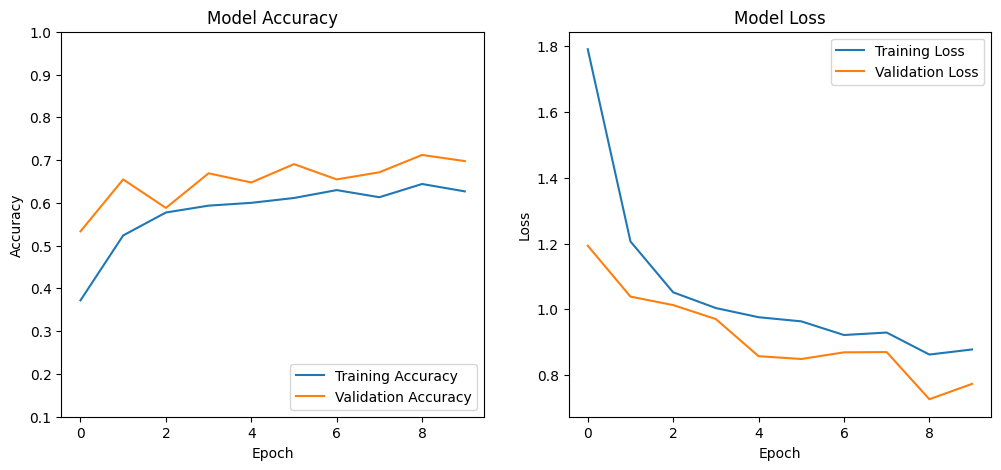

In [16]:
#Training accuracy and validation accuracy graph
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_CNN2['accuracy'])
plt.plot(history_CNN2['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0.1, 1)
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc ='lower right')

plt.subplot(1, 2, 2)
plt.plot(history_CNN2['loss'])
plt.plot(history_CNN2['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc ='upper right')

plt.show()

In [17]:
vgg_model.save('VGG16_model_0.5dropout.h5')

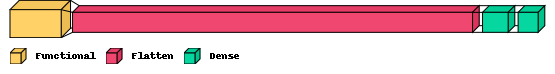

In [28]:
import visualkeras

visualkeras.layered_view(vgg_model,  legend=True)